# Is it possible to predict songs I will like before even listenning to them?
That's probably what Spotify's data scientists try to do and, in my opinion, succeed, as I think the suggestions they give me are pretty good (wouldn't say the same to Netflix).
<br>
<br>
**Today I challenged myself to see if I could do the same with a very simple model**. And, why not make from that exercise a result that I could use?
<br>
<br>
Giving some context, I'm a big Red Hot Chili Peppers fan, but, to be honest, I never spend time listenning to the old songs (pre Blood Sugar Sex Magik (1991)). I was introduced to the band on the Stadium Arcadium in 2006, moment when the band was switching from the funk rock to a more alternative rock style and since then I've been pretty much ignoring the pre 1991 songs. However, as a fan, I was questioning myself why I wouldn't give them a chance. So, to make this process easier i thought **why not using data to understand what songs I'll probabily like the most prior to 1991**
<br>
<br>
Fortunately, Spotify has a dedicated area on its app to extract a song's metrics. A step by step can be seen [here](https://medium.com/better-programming/how-to-extract-any-artists-data-using-spotify-s-api-python-and-spotipy-4c079401bc37). Since extracting the data wasn't the focus of the exercise, I took it organized from [a dataset on Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks#)
<br>
<br>
So my goal here is to get a list of songs from the Chili Peppers launched before 1991 that I'll probabily like based on the characteristics the songs I like have.

With such an easy access to the data, all i had to do was filtering the Chili Peppers song, creating a way of translating to a number how much I like a song and running the model

## What are the song's metrics?
More details [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/), but overall:
- duration_ms: The duration of the track in milliseconds.
- key: The estimated overall key of the track (help me here musicians. Don't know what that means)
- mode: indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy.
- instrumentalness: Predicts whether a track contains no vocals
- liveness: Detects the presence of an audience in the recording
- loudness: The overall loudness of a track in decibels (dB)
- speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric)
- tempo: The overall estimated tempo of a track in beats per minute (BPM)

Besides that, there is also release year and popularity as extra informations

# After the context, let's go for it: 

# 1- Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fklearn, matplotlib
from sklearn.model_selection import train_test_split
import seaborn as sns

# 2- Gathering the data

In [5]:
#Importing the data
data = pd.read_csv('data.csv') #taken from the Kaggle link on the description

In [7]:
#Adding a column that flags Red Hot songs
data['red_hot'] = data['artists'].str.contains('Red Hot Chili Peppers', regex=False)

#Filtering only the Red Hot songs
mask = data['red_hot'] == True
data_red_hot = data[mask]

#Filtering only the post 1991 Red Hot songs
mask = data_red_hot['year'] >= 1991
data_red_hot_short = data_red_hot[mask]

In [9]:
#Having a look at the dataframe
data_red_hot_short.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,red_hot
5170,0.00553,['Red Hot Chili Peppers'],0.562,71840,0.995,0,1jQ0EZPAY3HpBRgUev6X1Q,0.000223,7,0.136,-12.704,1,They're Red Hot,42,1991-09-24,0.1590,152.108,0.0392,1991,True
5212,0.00236,['Red Hot Chili Peppers'],0.709,216693,0.738,1,5guVvrqQlZVTnHky6gxVOP,0.795000,7,0.073,-12.019,1,If You Have to Ask,32,1991-09-24,0.0480,96.240,0.6710,1991,True
5558,0.00565,['Red Hot Chili Peppers'],0.439,248640,0.709,0,3iHvXVAXLpoGMWnDhpFspL,0.001520,0,0.131,-3.545,1,My Friends,44,1995-09-12,0.0260,81.331,0.3190,1995,True
6270,0.00856,['Red Hot Chili Peppers'],0.565,311693,0.776,0,2AkjEtum3SrtNW4WHZErTA,0.000136,4,0.111,-4.161,0,Dosed,49,2002-07-09,0.0282,104.346,0.3260,2002,True
6708,0.00624,['Red Hot Chili Peppers'],0.607,262333,0.890,0,4vHmY3cg7PWCPE0buO3G6t,0.135000,2,0.140,-3.148,1,21st Century,52,2006-05-09,0.0504,115.941,0.6710,2006,True


In [125]:
data_red_hot_short.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.050075,0.532291,252848.107595,0.798373,0.132911,0.053183,4.930380,0.171077,-5.686038,0.569620,52.348101,0.066991,117.993525,0.507384,1999.955696
std,0.100052,0.124486,55801.261382,0.181058,0.340558,0.150158,3.667931,0.109323,3.634757,0.496704,10.911881,0.051591,25.736307,0.221208,6.485992
min,0.000014,0.241000,71840.000000,0.150000,0.000000,0.000000,0.000000,0.027300,-13.591000,0.000000,28.000000,0.022800,78.531000,0.039200,1991.000000
25%,0.002360,0.444250,217013.000000,0.721500,0.000000,0.000009,1.250000,0.094050,-8.200000,0.000000,46.250000,0.036475,97.646250,0.335750,1995.000000
50%,0.011300,0.556000,249513.500000,0.825000,0.000000,0.000304,5.000000,0.122500,-4.138000,1.000000,51.000000,0.049200,113.695500,0.506500,2000.500000
75%,0.061950,0.611000,282160.000000,0.942750,0.000000,0.004340,8.750000,0.261750,-3.105000,1.000000,59.000000,0.072475,130.943750,0.698750,2005.250000
max,0.836000,0.852000,496627.000000,0.995000,1.000000,0.795000,11.000000,0.564000,-0.320000,1.000000,81.000000,0.342000,204.026000,0.960000,2016.000000


# 3- Droping duplicates

There are songs with more than one version, but with very similar characteristics. It makes sense to leave only one and I'll leave only the first version of the song

In [10]:
data_red_hot_short2 = data_red_hot_short.sort_values(by='year', ascending=True).drop_duplicates(subset=['name'], keep='first')

In [11]:
data_red_hot_short2.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,0.059020,0.534721,252834.884615,0.796865,0.105769,0.047338,5.076923,0.174348,-5.548654,0.548077,53.298077,0.066562,119.530106,0.499730,2001.000000
std,0.110734,0.129810,55900.979010,0.179649,0.309031,0.142668,3.595284,0.111735,3.425013,0.500093,9.781973,0.050376,26.540087,0.225168,6.933806
min,0.000014,0.241000,71840.000000,0.150000,0.000000,0.000000,0.000000,0.027300,-13.591000,0.000000,28.000000,0.022800,78.531000,0.039200,1991.000000
25%,0.003048,0.455750,217093.000000,0.720000,0.000000,0.000007,2.000000,0.094150,-7.605250,0.000000,48.000000,0.036100,100.505250,0.326000,1995.000000
50%,0.013750,0.555000,249513.500000,0.828500,0.000000,0.000139,5.000000,0.125500,-4.150000,1.000000,52.000000,0.049200,113.958000,0.472500,2002.000000
75%,0.073700,0.620750,282526.750000,0.937500,0.000000,0.004085,8.000000,0.259250,-3.151750,1.000000,60.000000,0.072825,132.435750,0.673250,2006.000000
max,0.836000,0.852000,496627.000000,0.995000,1.000000,0.795000,11.000000,0.564000,-0.320000,1.000000,81.000000,0.342000,204.026000,0.960000,2016.000000


# 4- Giving my grades

To measure how much I like a song, I coudn't think of a simpler way than grading the ~100 songs from 1 to 5 manually. Would be nice to use a more data drive metric, such as count of times I listened to each of them, but I couldn't find a way to get my hands on that sort of data  

I tried to grade as uniformily between the 5 grades as I could

In [13]:
d = {"They're Red Hot": 1, 
     'Little Miss Lover - 2006 Remaster': 1, 
     'Castles Made of Sand - 2006 Remaster': 2,
     'If You Have to Ask': 2,
     'The Righteous & the Wicked': 1,
     'Mellowship Slinky in B Major': 1,
     'Sir Psycho Sexy': 5,
     'The Power of Equality': 2,
     'Naked in the Rain': 3,
     'Funky Monks': 1,
     'Suck My Kiss': 4,
     'Give It Away': 3,
     'Under the Bridge': 5,
     'Apache Rose Peacock': 2,
     'I Could Have Lied': 4,
     'The Greeting Song': 1,
     'My Lovely Man': 1,
     'Blood Sugar Sex Magik': 4,
     'Breaking the Girl': 4,
     'Sikamikanico': 1,
     'Show Me Your Soul': 1,
     'Higher Ground': 3,
     'Fight Like A Brave': 1,
     'Aeroplane': 4,
     'Tearjerker': 1,
     'Warped': 1,
     'Walkabout': 1,
     'My Friends': 4,
     'I Like Dirt': 2,
     'Savior': 2,
     'Emit Remmus': 2,
     'Fat Dance - 2006 Remaster': 1, 
     'Purple Stain': 2,
     'Californication': 5,
     'Right on Time': 4,
     'Quixoticelixer - 2006 Remaster': 5,
     'Porcelain': 1,
     'Otherside': 5,
     'Scar Tissue': 5,
     'Around the World': 5,
     'Parallel Universe': 3,
     'Over Funk - 2006 Remaster': 1, 
     'Easily': 2,
     'This Velvet Glove': 3,
     "Road Trippin'": 2,
     'Get on Top': 3,
     'This Is the Place': 4,
     'Warm Tape': 3,
     'Runaway - 2006 Remaster': 3,
     "Don't Forget Me": 3,
     'Bicycle Song - 2006 Remaster': 4,
     'On Mercury': 3,
     'The Zephyr Song': 5,
     'Minor Thing': 3,
     'Universally Speaking': 4,
     'Midnight': 3,
     'Cabron': 2,
     'Dosed': 4,
     'Tear': 5,
     'Venice Queen': 5,
     'I Could Die for You': 3,
     'By the Way': 5,
     'Throw Away Your Television': 1,
     "Can't Stop": 5,
     'Soul to Squeeze': 4,
     'Fortune Faded': 4,
     'We Believe': 2,
     'Dani California': 5,
     'Stadium Arcadium': 4,
     'Especially in Michigan': 4,
     'Slow Cheetah': 5,
     'Hey': 3,
     'Make You Feel Better': 3,
     'Charlie': 2,
     'Tell Me Baby': 4,
     "She's Only 18": 3,
     'Hard to Concentrate': 5,
     'Hump de Bump': 2,
     'Snow (Hey Oh)': 5,
     'Wet Sand': 5,
     'So Much I': 2,
     'She Looks to Me': 4,
     'Death of a Martian': 5,
     'Desecration Smile': 4,
     'If': 2,
     'Storm in a Teacup': 3,
     'Animal Bar': 3,
     'Strip My Mind': 3,
     'Warlocks': 3,
     "C'mon Girl": 2,
     'Readymade': 4,
     '21st Century': 3,
     'Torture Me': 2,
     'Turn It Again': 3,
     'The Adventures of Rain Dance Maggie': 5,
     'Police Station': 3,
     "Brendan's Death Song": 4,
     'Look Around': 4,
     'Dark Necessities': 5,
     'Goodbye Angels': 4,
     'The Longest Wave': 4,
     'Sick Love': 3,
     'The Getaway': 4,
     'Go Robot': 4
     
     
    }
data_red_hot_short2['grade'] = data_red_hot_short2['name'].map(d)

In [15]:
#Chacking if I graded all of them
data_red_hot_short2.isna().mean()

acousticness        0.0
artists             0.0
danceability        0.0
duration_ms         0.0
energy              0.0
explicit            0.0
id                  0.0
instrumentalness    0.0
key                 0.0
liveness            0.0
loudness            0.0
mode                0.0
name                0.0
popularity          0.0
release_date        0.0
speechiness         0.0
tempo               0.0
valence             0.0
year                0.0
red_hot             0.0
grade               0.0
dtype: float64

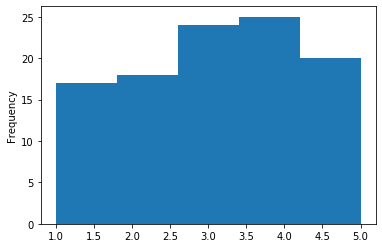

In [16]:
#Checking if the grades were well distributed
data_red_hot_short2['grade'].plot.hist(bins = 5)

In [42]:
data_red_hot_short2['grade'].mean()

3.125

Guess it's fine

# 5- Understandig the metrics and the correlation with the target

In [160]:
# sns.pairplot(data_red_hot_short2)

In [26]:
metrics_to_plot = [col for col in data.columns if col not in [
    'duration_ms',
    'year',
    'popularity',
    'tempo',
    'loudness',
    'key',
    'red_hot'
     ]]

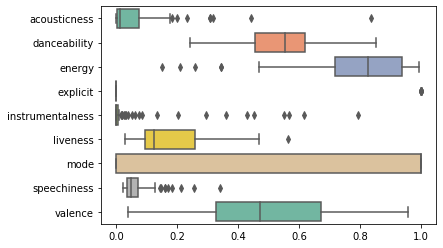

In [27]:
ax = sns.boxplot(data=data_red_hot_short2[metrics_to_plot], orient="h", palette="Set2")

Explicit and intrumentalness features won't add much value to the model

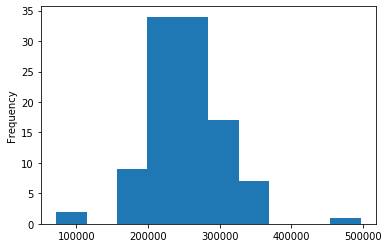

In [28]:
data_red_hot_short2['duration_ms'].plot.hist(bins = 10)

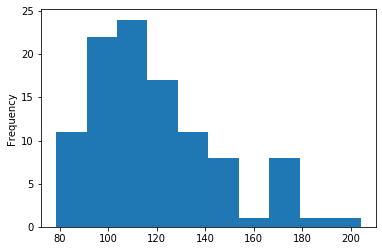

In [29]:
data_red_hot_short2['tempo'].plot.hist(bins = 10)

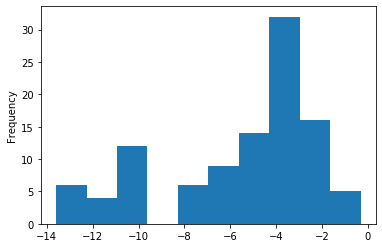

In [30]:
data_red_hot_short2['loudness'].plot.hist(bins = 10)

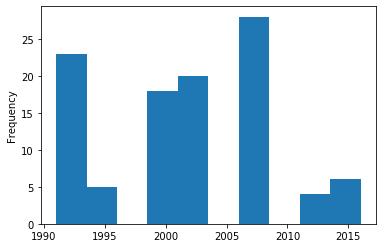

In [31]:
data_red_hot_short2['year'].plot.hist(bins = 10)

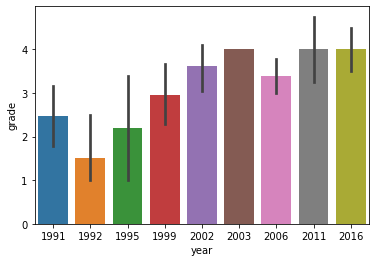

In [32]:
#Grade average through the years
ax = sns.barplot(x="year", y="grade", data=data_red_hot_short2)

Guess it is true that I like more the newest songs

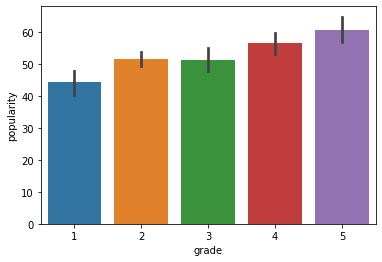

In [33]:
#Average popularuty grouped by grade
ax = sns.barplot(x="grade", y="popularity", data=data_red_hot_short2)

### Well, guess I'm not hipster

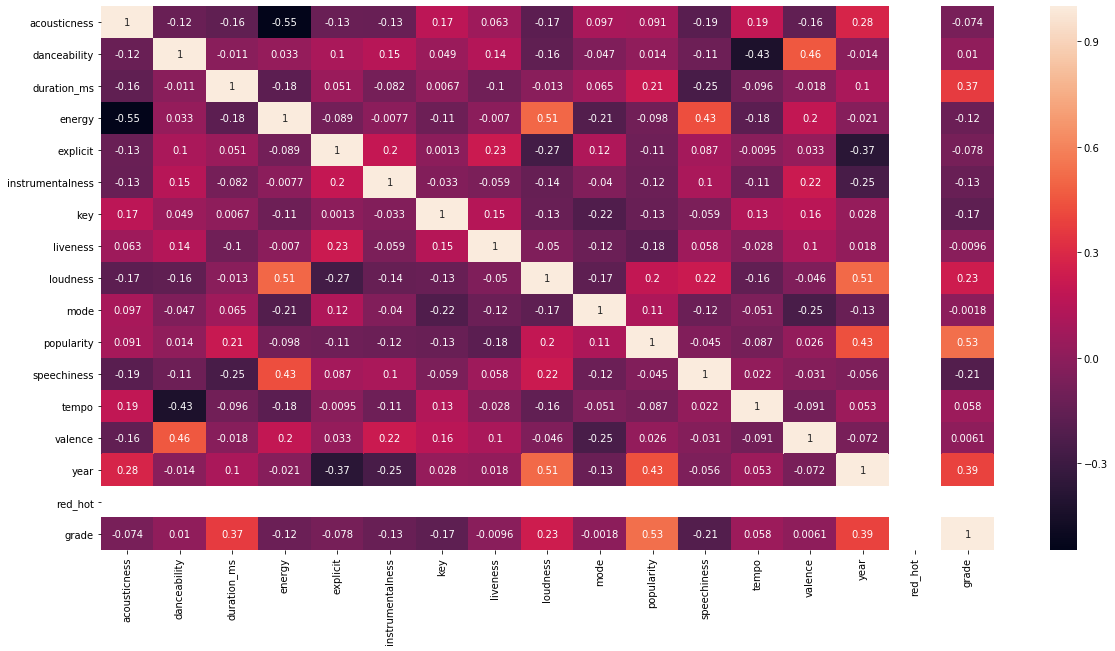

In [35]:
#Correlation matrix
plt.figure(figsize = (20, 10))
sns.heatmap(data_red_hot_short2.corr(), annot = True)

Not many strong correlations with the target (grade)

### Having understood the features and target characteristics, let's write (recycle) the model

# 6- Model

## Train test split

In [36]:
train_df, test_df = train_test_split(data_red_hot_short2, test_size=0.2, random_state=50)

## Feature list

In [38]:
target = 'grade'

features = [col for col in data.columns if col not in [
    'artists',
    'id',
    'name',
    'release_date',
    'red_hot',
    'grade'
     ]]

## I will be using a gradient boosting model because it is effective

In [39]:
from fklearn.training.regression import xgb_regression_learner

param = {'max_depth':1, 'n_estimators':10}

xgb_fn, _, _ = xgb_regression_learner(features = features, target=target, extra_params = param)(train_df)

[01:20:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
#Displaying train df with prediction
xgb_fn(train_df).head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,red_hot,grade,prediction
166998,0.000271,['Red Hot Chili Peppers'],0.585,158550,0.980,0,1CNDe1BS7dKfUsYb5vm5rO,0.000025,1,0.0273,...,Little Miss Lover - 2006 Remaster,42,1991-09-24,0.1200,94.775,0.470,1991,True,1,1.452268
30422,0.098500,['Red Hot Chili Peppers'],0.377,192827,0.734,0,3EAcsZy8hsDrDoTaM13ewu,0.000000,9,0.0942,...,I Could Die for You,46,2002-07-09,0.0334,169.988,0.393,2002,True,3,3.016548
45163,0.002180,['Red Hot Chili Peppers'],0.459,193507,0.962,0,7G3d1rttNC54yaHiQfEO7p,0.050300,2,0.1880,...,The Greeting Song,28,1991-09-24,0.0485,134.139,0.307,1991,True,1,1.735826
115026,0.001630,['Red Hot Chili Peppers'],0.524,201267,0.946,0,37sSud1ZrTpwXPGJP0dbXI,0.000000,11,0.2420,...,Fortune Faded,59,2003-11-18,0.0395,119.156,0.613,2003,True,4,3.556945
123221,0.001680,['Red Hot Chili Peppers'],0.567,323333,0.659,0,68uWKoPwSxYE6DVylRA1XI,0.001580,0,0.0513,...,Funky Monks,52,1991-09-24,0.0499,90.519,0.610,1991,True,1,2.029921


In [41]:
#Displaying train df with prediction
xgb_fn(test_df).head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,name,popularity,release_date,speechiness,tempo,valence,year,red_hot,grade,prediction
124774,0.000858,['Red Hot Chili Peppers'],0.468,240333,0.826,0,1ylzYcU6FGnuBqqdqqH7QL,0.000005,6,0.1040,...,Especially in Michigan,59,2006-05-09,0.0295,102.817,0.359,2006,True,4,3.794356
132570,0.141000,['Red Hot Chili Peppers'],0.543,198689,0.582,0,7mUNyl16vX2OrKqMAuZJF9,0.000224,11,0.0929,...,Castles Made of Sand - 2006 Remaster,47,1991-09-24,0.0580,150.459,0.600,1991,True,2,2.165729
161095,0.183000,['Red Hot Chili Peppers'],0.591,221440,0.794,0,6GsP3uMCd0Dn5T37C93waZ,0.000000,4,0.2920,...,Sick Love,65,2016-06-17,0.0690,147.974,0.875,2016,True,3,3.943834
6739,0.013500,['Red Hot Chili Peppers'],0.524,270467,0.945,0,2Y5ngAobMcspRywfmb77k5,0.003320,11,0.1080,...,Readymade,51,2006-05-09,0.0797,149.819,0.800,2006,True,4,3.275183
23834,0.043200,['Red Hot Chili Peppers'],0.852,263800,0.651,0,5m578MgxuEC956dulprCe8,0.019200,8,0.1580,...,Go Robot,63,2016-06-17,0.0411,131.010,0.960,2016,True,4,3.667824


## Checking the errors metrics

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr

def evaluate_pred(df_pred, target, prediction):
    
    print("R2:                                      ", r2_score(df_pred[target], df_pred[prediction]))
    print("Spearman:                                ", spearmanr(df_pred[target], df_pred[prediction])[0])


In [44]:
#Train df
evaluate_pred(xgb_fn(train_df), target, "prediction")

R2:                                       0.679428424711801
Spearman:                                 0.8485640911273903


In [46]:
#Test df
evaluate_pred(xgb_fn(test_df), target, "prediction")

R2:                                       0.39021410169465576
Spearman:                                 0.649134748242552


Not the best results, but at least greater than zero. Spearman is good enough

In [47]:
#Saving the prediction in a val
test_pred = xgb_fn(test_df)

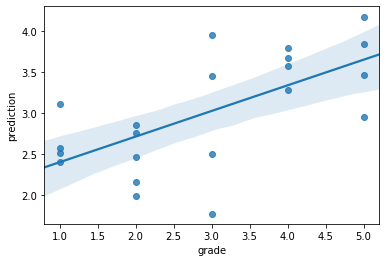

In [48]:
#Understanding how the actual grade vs the grade prediction scatter looks like
import seaborn as sns
tips = sns.load_dataset("tips")
ax = sns.regplot(x="grade", y="prediction", data=test_pred)

The model was able to order relatively well the grades, but got confused with the threes. Notice that the test sample size is pretty small, but increasing its proportion vs train wasn't effective

# Feature importance

In [49]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(max_depth=1, num_estimators=10)
xgb_model.fit(train_df[features].values, train_df[target].values)

[01:26:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_estimators=10, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [50]:
# SHAP values
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(train_df[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


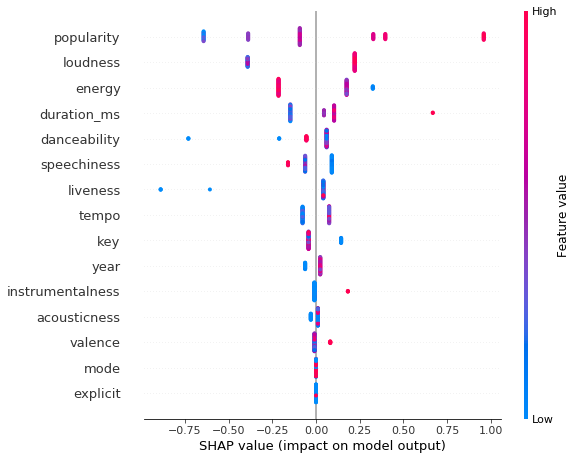

In [52]:
# summarize the effects of all the features
shap.summary_plot(shap_values, train_df[features])

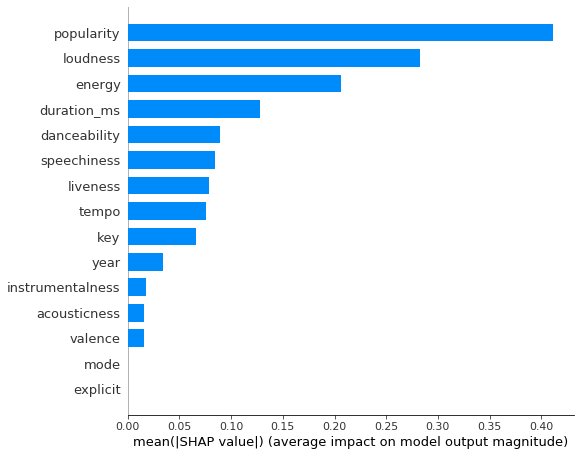

In [53]:
shap.summary_plot(shap_values, train_df[features], plot_type="bar")

As expected, popularity has a great importance in the prediction. Also, nice to see that I prefer low energy songs, which makes sense as I mentioned that I like the alternative rock phase more than the funk one (more energetic)

# 7- What pre 1991 Red Hot songs should I start listenning to?

In [56]:
mask = data_red_hot['year'] < 1991
data_pre_1991 = data_red_hot[mask]

listen_to_df = xgb_fn(data_pre_1991)
listen_to_df_sorted = listen_to_df.sort_values(by='prediction', ascending=False)
listen_to_df_sorted[['name', 'prediction']].head(5)

,name,prediction
84874,Higher Ground - Remastered,3.950007
4776,Behind The Sun,3.174353
37113,Song That Made Us What We Are Today,2.928158
94723,Pretty Little Ditty - Remastered,2.907462
66971,Grand Pappy Du Plenty - 2002 Digital Remaster,2.885607


### Great! adding to queue... 

In [60]:
#Mean prediction of the pre 1991 songs
listen_to_df['prediction'].mean()

2.1477618

In [61]:
#Mean prediction of the test songs
xgb_fn(test_df)['prediction'].mean()

3.0098536

Notice how the pre 1991 have a prediction mean lower than the train df. Makes sense as I mentioned that I don't really like the pre 1991 era

# 8- What other songs besides Red Hot's should I listen to?

In [332]:
mask = data['red_hot'] == False
data_not_red_hot = data[mask]

listen_to_df = xgb_fn(data_not_red_hot)
listen_to_df_ordered = listen_to_df.sort_values(by='prediction', ascending=False)
listen_to_df_ordered[['artists','name']].head(10)

,artists,name
7959,"['Bethel Music', 'Jonathan David Helser', 'Mel...",Raise a Hallelujah (Live)
86967,"['Kanye West', 'Pusha T']",Runaway
32149,['The Strokes'],Eternal Summer
16053,"['Nio Garcia', 'Rauw Alejandro', 'Lenny Taváre...",Mírame - Remix
7822,"['Wisin', 'Ozuna', 'Bad Bunny', 'De La Ghetto'...","Escápate Conmigo (feat. Ozuna, Bad Bunny, De L..."
135082,['Kanye West'],Saint Pablo
144235,['Tame Impala'],Breathe Deeper
86924,['Eminem'],Beautiful
106409,['Ben Howard'],Promise
96846,['Ed Sheeran'],Give Me Love


One church song, one modern rap and one hipster indie on top 3...

# 9- Model limitations:
- The year feature in the model doesn't exactly bring seasonal information, but rather explains the album the song is at. When looking outside the Red Hot spectrum, I'm probably overfitting the year 
- I wrote the grades knowing the purpose of them. So there probably is a little bit of unconscious bias, even though I tried to not think about it
- The model seems to be dependent on the Popularity feature, which is not good if I try to predict songs that just got released, as it is an information that varies through time

# 10- Checking the performance without the Popularity feature

In [62]:
target = 'grade'

features = [col for col in data.columns if col not in [
    'artists',
    'id',
    'name',
    'release_date',
    'red_hot',
    'grade',
    'popularity'
     ]]

from fklearn.training.regression import xgb_regression_learner
param = {'max_depth':1, 'n_estimators':10}
xgb_fn2, _, _ = xgb_regression_learner(features = features, target=target, extra_params = param)(train_df)

evaluate_pred(xgb_fn2(test_df), target, "prediction")

[01:39:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2:                                       0.13644721566353413
Spearman:                                 0.46300529491994274


Significantly worse

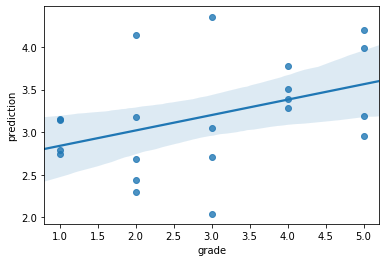

In [63]:
import seaborn as sns
tips = sns.load_dataset("tips")
ax = sns.regplot(x="grade", y="prediction", data=xgb_fn2(test_df))

# 11 - Conclusion

The model isn't great, but reaches its purpose of selecting a set of songs to give it a try as at least its Spearman is fine. It can be improved mainly if I find a better way of measuring how much I like a song, so it would be more data driven and I would also use data from other artists to increase the sample size